# SO using the SimOpt library

In [21]:
import simopt
from simopt import base, models, solvers, experiment_base
from mrg32k3a.mrg32k3a import MRG32k3a
import numpy as np

## M/M/1 Queue

Here we run a single replication of an M/M/1 queue and report several outputs of interest. 

In [2]:
# Set up model
fixed_factors = {"lambda": 3.0, "mu": 8.0}
mymodel = models.mm1queue.MM1Queue(fixed_factors)
# Generate random numbers
# Here mymodel.n_rngs is 2 - the number of random number streams we use - one for service times, one for inter arrival times
rng_list = [MRG32k3a(s_ss_sss_index=[0, ss, 0]) for ss in range(mymodel.n_rngs)]


In [3]:
# Report data collection details
print('Model Parameters')
print('----------------')
print('The arrival rate is: ' + str(fixed_factors['lambda']))
print('The service rate is: ' + str(fixed_factors['mu']))

print('\nData collection')
print('----------------')
print('We allow a warm up of ' + str(mymodel.specifications['warmup']['default']) + ' people before calculating statistics based on ' + str(mymodel.specifications['people']['default']) + ' people.')

# Run a single replication of the model.
responses, gradients = mymodel.replicate(rng_list)
print('\nOutputs')
print('----------------')
print("For a single replication:")
print("Responses:")
for key, value in responses.items():
    print(f"\t {key} is {round(value,2)}.")

Model Parameters
----------------
The arrival rate is: 3.0
The service rate is: 8.0

Data collection
----------------
We allow a warm up of 20 people before calculating statistics based on 50 people.

Outputs
----------------
For a single replication:
Responses:
	 avg_sojourn_time is 0.18.
	 avg_waiting_time is 0.06.
	 frac_cust_wait is 0.36.


## Minimising the mean sojourn time in the M/M/1 queue

Here we introduce an objective function and solution space for a problem involving the M/M/1 queue. 

In [4]:
myproblem = models.mm1queue.MM1MinMeanSojournTime()
print ('\n The decision variable is the service rate: ' + str(myproblem.model_decision_factors))


 The decision variable is the service rate: {'mu'}


There is a cost $c$ associated with increasing the service rate $\mu$. 

In [5]:
print(' c: ' + str(myproblem.specifications['cost']['default']) + ' is the cost per unit increase of service rate.')

 c: 0.1 is the cost per unit increase of service rate.


The objective $f(\mu; \xi, c) = y(\mu; \xi) + c**2$ where $y(\cdot)$ is the mean sojourn time and we wish to minimise this objective function. 

In [6]:
print('Solution space')
print('----------------')
print('The solution space is ' + str(myproblem.variable_type) + ' with lower bound ' + str(myproblem.lower_bounds[0]) + ' and upper bound ' + str(myproblem.upper_bounds[0]))

print('\nModel Parameters')
print('----------------')
print('lambda: ' + str(myproblem.model.specifications['lambda']['default']) + ' is the arrival rate.')

print('\nData collection')
print('----------------')
print('We allow a warm up of ' + str(mymodel.specifications['warmup']['default']) + ' people before calculating statistics based on ' + str(mymodel.specifications['people']['default']) + ' people.')

Solution space
----------------
The solution space is continuous with lower bound 0 and upper bound inf

Model Parameters
----------------
lambda: 1.5 is the arrival rate.

Data collection
----------------
We allow a warm up of 20 people before calculating statistics based on 50 people.


We now run 10 simulation replications for a given solution and report the objective function values. 

In [7]:
x = (5,)
mysolution = base.Solution(x, myproblem)

# Create and attach rngs to solution
rng_list = [MRG32k3a(s_ss_sss_index=[0, ss, 0]) for ss in range(myproblem.model.n_rngs)]
mysolution.attach_rngs(rng_list, copy=False)

# Simulate a fixed number of replications (n_reps) at the solution x.
n_reps = 10
myproblem.simulate(mysolution, m=n_reps)

# Print results to console.
print(f"Ran {n_reps} replications of the {myproblem.name} problem at solution x = {x}.\n")
print(f"The mean objective estimate was {round(mysolution.objectives_mean[0], 4)} with standard error {round(mysolution.objectives_stderr[0], 4)}.")
print("The individual observations of the objective were:")
for idx in range(n_reps):
    print(f"\t {round(mysolution.objectives[idx][0], 4)}")

Ran 10 replications of the MM1-1 problem at solution x = (8,).

The mean objective estimate was 6.5576 with standard error 0.0051.
The individual observations of the objective were:
	 6.5544
	 6.5771
	 6.5411
	 6.5453
	 6.5431
	 6.535
	 6.5687
	 6.5706
	 6.5798
	 6.5604


### How the solvers work
Each solver is run a number of times (set as the number of macro-replications) on the problem. Each macro-replication involves a different random number stream. During each macroreplication, a solver will start with an initial solution (the initial 'current best') and at certain points in the simulation budget will update its recording of the current best solution. Post-replications are performed on each solution which was considered a 'current best' at any time during the macro-replication. 

The solver then selects the optimal solution as the best of all solutions which were post-replicated. Further post-replications are performed on the initial and optimal solution - this is used to calculate an optimality gap which is used for normalising the progress curves of the solver. 

Bootstrap samples (default 100) of the progress curves are taken, and then CI intervals are applied to plot the progress of the algorithm over the course of the simulation budget. 

## Testing the Random Search solver

Here we use the Random search solver to look for an optimal solution to this problem. We report the performance of this solver

### How the solver works
The solver starts at a given initial solution (which starts of as the 'current best') and then at each iteration moves to a randomly selected new solution. New random solutions are random samples from exponential distribution with rate 1/3. At each selected solution, 10 simulation replications are performed, and the mean objective value is calculated. Whenever a solution's mean objective is better than the current best, it is updated to be the current best. This process is repeated, using common random numbers at each solution, until the simulated budget is exhausted. 


In [9]:
### Outputs
solver_name = "RNDSRCH"
problem_name = "MM1-1"

# Initialize an instance of the experiment class.
myexperiment = experiment_base.ProblemSolver(solver_name, problem_name)

# Run a fixed number of macroreplications of the solver on the problem.
myexperiment.run(n_macroreps=10)

# Run a fixed number of postreplications at all recommended solutions.
myexperiment.post_replicate(n_postreps=100)
# Find an optimal solution x* for normalization.
experiment_base.post_normalize([myexperiment], n_postreps_init_opt=100)

Running macroreplication 1 of 10 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 2 of 10 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 3 of 10 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 4 of 10 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 5 of 10 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 6 of 10 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 7 of 10 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 8 of 10 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 9 of 10 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 10 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 1 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 2 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 3 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 4 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 5 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 6 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 7 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 8 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 9 of 10 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 10 of 10 of Solver RNDSRCH on Problem MM1-1.


Postnormalizing on Problem MM1-1.


Finding f(x*)...
	...using best postreplicated solution as proxy for x*.


In [10]:
myexperiment.log_experiment_results()

Below is a summary of the model factors, problem factors and solver factors, and high level details of the results of the experiment using the random search solver on the problem with the M/M/1 queue. The subsequent plot illustrates the performance of the solver as simulation budget is expended. The performance is quantified in terms of the fraction of the optimality gap remaining versus how much simulation budget has been used. The confidence intervals are calculated using bootstrapped samples of the current best solution at different points of the budget and the objective values of those solutions. 

In [25]:
print(f"Solver: {myexperiment.solver.name}\n")
print("Model Factors:")
for key, value in myexperiment.problem.model.factors.items():
    # Excluding model factors corresponding to decision variables.
    if key not in myexperiment.problem.model_decision_factors:
        print(f"\t{key}: {value}")
print('\n')
        
print("Problem Factors:")
for key, value in myexperiment.problem.factors.items():
    print(f"\t{key}: {value}")
print('\n')

print("Solver Factors:")
for key, value in myexperiment.solver.factors.items():
    print(f"\t{key}: {value}")
print('\n')
    
# Display macroreplication information.
print(f"{myexperiment.n_macroreps} macroreplications were run.\n")
# If results have been postreplicated, list the number of post-replications.
if myexperiment.check_postreplicate():
    print(f"{myexperiment.n_postreps} postreplications were run at each recommended solution.\n\n")
# If post-normalized, state initial solution (x0) and proxy optimal solution (x_star)
# and how many replications were taken of them (n_postreps_init_opt).
if myexperiment.check_postnormalize():
    print(f"The initial solution is {tuple([round(x, 4) for x in myexperiment.x0])}. Its estimated objective is {round(np.mean(myexperiment.x0_postreps), 4)}.\n")
    if myexperiment.xstar is None:
        print(f"No proxy optimal solution was used. A proxy optimal objective function value of {myexperiment.problem.optimal_value[0]} was provided.\n")
    else:
        print(f"The proxy optimal solution is {tuple([round(x, 4) for x in myexperiment.xstar])}. Its estimated objective is {round(np.mean(myexperiment.xstar_postreps), 4)}.\n")
    print(f"{myexperiment.n_postreps_init_opt} postreplications were taken at x0 and x_star.\n\n")


Solver: RNDSRCH

Model Factors:
	warmup: 50
	people: 200
	lambda: 1.5


Problem Factors:
	initial_solution: (5,)
	budget: 1000
	cost: 0.1


Solver Factors:
	crn_across_solns: True
	sample_size: 10


10 macroreplications were run.

100 postreplications were run at each recommended solution.


The initial solution is (5,). Its estimated objective is 2.7844.

The proxy optimal solution is (2.8243,). Its estimated objective is 1.5488.

100 postreplications were taken at x0 and x_star.




['experiments/plots/SOLVER_SET_on_MM1-1_mean_prog_curve.png']

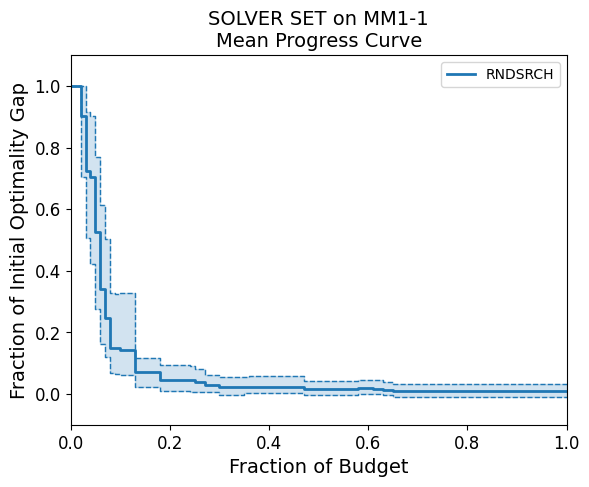

In [26]:
experiment_base.plot_progress_curves(experiments=[myexperiment], plot_type="mean", normalize=True,  print_max_hw=False)

We next use two other solvers (alongside the random search solver) to solve the problem based on the M/M/1 queue. The solvers we have chosen are called 'STRONG' and 'ADAM'. Below we give a brief description of how each of these solvers works, and the fsubsequent plot illustrates the performance of the solver as simulation budget is expended. The performance is quantified in terms of the probability that the solver can come close to the optimal solution given a certain proportion of budget expenditure. 'Close to optimal' is defined as within 10% of the optimality gap. The confidence intervals are calculated using bootstrapped samples of the current best solution at different points of the budget and the objective values of those solutions. 

Running 20 macro-replications of RNDSRCH on MM1-1.
Running macroreplication 1 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 2 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 3 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 4 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 5 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 6 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 7 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 8 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 9 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 10 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 11 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 12 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 13 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 14 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 15 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 16 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 17 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 18 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 19 of 20 of Solver RNDSRCH on Problem MM1-1.


Running macroreplication 20 of 20 of Solver RNDSRCH on Problem MM1-1.


Running 20 macro-replications of STRONG on MM1-1.
Running macroreplication 1 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 2 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 3 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 4 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 5 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 6 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 7 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 8 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 9 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 10 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 11 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 12 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 13 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 14 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 15 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 16 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 17 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 18 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 19 of 20 of Solver STRONG on Problem MM1-1.


Running macroreplication 20 of 20 of Solver STRONG on Problem MM1-1.


Running 20 macro-replications of ADAM on MM1-1.
Running macroreplication 1 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 2 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 3 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 4 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 5 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 6 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 7 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 8 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 9 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 10 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 11 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 12 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 13 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 14 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 15 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 16 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 17 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 18 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 19 of 20 of Solver ADAM on Problem MM1-1.


Running macroreplication 20 of 20 of Solver ADAM on Problem MM1-1.


Post-processing results.
Post-processing RNDSRCH on MM1-1.
Postreplicating macroreplication 1 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 2 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 3 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 4 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 5 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 6 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 7 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 8 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 9 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 10 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 11 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 12 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 13 of 20 of Solver RNDSRCH on Problem MM1-1.
Postreplicating macroreplication 14 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 15 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 16 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 17 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 18 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 19 of 20 of Solver RNDSRCH on Problem MM1-1.


Postreplicating macroreplication 20 of 20 of Solver RNDSRCH on Problem MM1-1.


Post-processing STRONG on MM1-1.
Postreplicating macroreplication 1 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 2 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 3 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 4 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 5 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 6 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 7 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 8 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 9 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 10 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 11 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 12 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 13 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 14 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 15 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 16 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 17 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 18 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 19 of 20 of Solver STRONG on Problem MM1-1.


Postreplicating macroreplication 20 of 20 of Solver STRONG on Problem MM1-1.


Post-processing ADAM on MM1-1.
Postreplicating macroreplication 1 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 2 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 3 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 4 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 5 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 6 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 7 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 8 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 9 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 10 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 11 of 20 of Solver ADAM on Problem MM1-1.
Postreplicating macroreplication 12 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 13 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 14 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 15 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 16 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 17 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 18 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 19 of 20 of Solver ADAM on Problem MM1-1.


Postreplicating macroreplication 20 of 20 of Solver ADAM on Problem MM1-1.


Postnormalizing on Problem MM1-1.


Finding f(x*)...
	...using best postreplicated solution as proxy for x*.


Plotting results.


Finished. Plots can be found in experiments/plots folder.


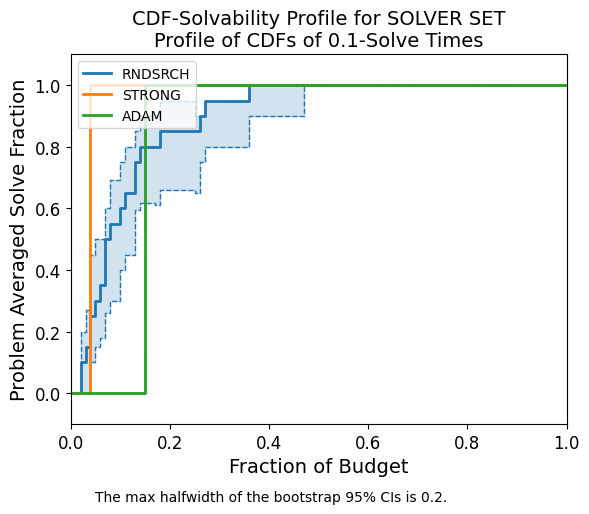

In [32]:
solver_names = ["RNDSRCH", "STRONG", 'ADAM']
problem_names = ["MM1-1"]

# Initialize an instance of the experiment class.
mymetaexperiment = experiment_base.ProblemsSolvers(solver_names, problem_names)

# Write to log file.
mymetaexperiment.log_group_experiment_results()

# Run a fixed number of macroreplications of each solver on each problem.
mymetaexperiment.run(n_macroreps=20)

print("Post-processing results.")
# Run a fixed number of postreplications at all recommended solutions.
mymetaexperiment.post_replicate(n_postreps=100)
# Find an optimal solution x* for normalization.
mymetaexperiment.post_normalize(n_postreps_init_opt=100)

print("Plotting results.")
# Produce basic plots of the solvers on the problems.
experiment_base.plot_solvability_profiles(experiments=mymetaexperiment.experiments, plot_type="cdf_solvability")

# Plots will be saved in the folder experiments/plots.
print("Finished. Plots can be found in experiments/plots folder.")

Plotting results.


['experiments/plots/SOLVER_SET_on_PROBLEM_SET_profile_cdf_0.1_solve_times.png']

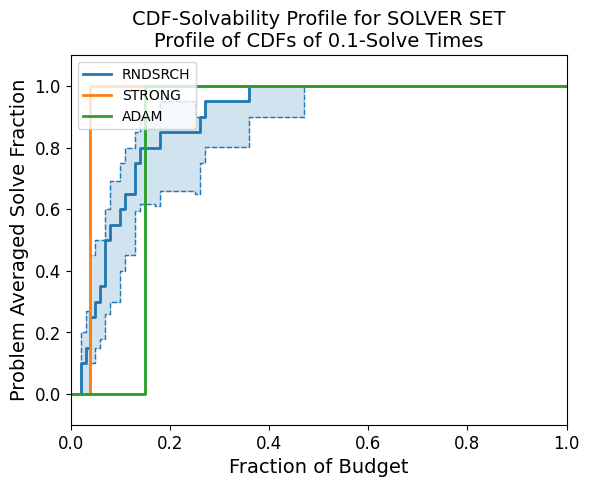

In [34]:
print("Plotting results.")
# Produce basic plots of the solvers on the problems.
experiment_base.plot_solvability_profiles(experiments=mymetaexperiment.experiments, plot_type="cdf_solvability", print_max_hw = False)
